In [37]:
# load the saved parameters and do visualization for W, a and C_alpha.
import numpy as np
import matplotlib.pyplot as plt
import pickle

path = '/data3/wangshaobo/ICL/RPE/results_paper/NGram/C_W_a_parent3_n10000_L100_S3_H5_1.0_1.0_1.0_optsgd_w+2.0_w-0.01_D-1_c_alpha_init0.01_a_init0.01_alpha0.1_n-epochs[100, 100, 10].npz'
data = np.load(path)

# extract info from path, about L, S, H
path = path.split('/')[-1]
path = path.split('_')
L = int(path[5][1:])
S = int(path[6][1:])
H = int(path[7][1:])
D = path[14][1:]
print('L, S, H, D', L, S, H, D)



L, S, H, D 100 3 5 -1


In [38]:
# check the dict of data saved with npz
print(data.files)
alphas = data['alphas']

['C_list', 'train_loss_list_1', 'val_loss_list_1', 'alphas', 'W_before', 'train_loss_list_2', 'val_loss_list_2', 'W_after', 'a_list', 'train_loss_list_3', 'val_loss_list_3']


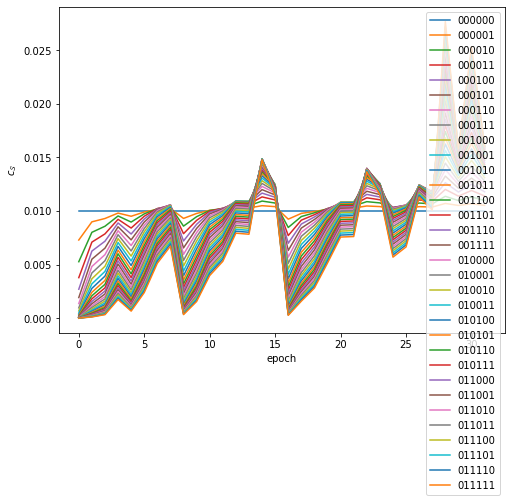

In [39]:
# plot C_list curve, C_list is a list of multiple C_alpha, draw the curve of each alpha.
# each alpha is corrensding to a binary coding of H+1 positions, change alpha to binary, then to a list of 0 and 1.
C_list = data['C_list']
plt.figure(figsize=(8,6))
for i, (alpha, C_alpha) in enumerate(zip(alphas, C_list)):
    plt.plot(C_list[i], label = alpha)
    plt.legend()
plt.xlabel('epoch')
plt.ylabel(r'$c_\mathcal{S}$')
plt.show()

In [41]:
len(alphas)

32